<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Fuel efficiency prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, and then leverage an auto-machine learning (AutoML) library called [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model acchitectures.

# Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


In [13]:
!pip install -q seaborn ## Use seaborn for pairplot
!pip install -q tpot  # Use TPOT for automl

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


# Task 1. Data: Auto MPG dataset

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [16]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [17]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [18]:
dataset = dataset.dropna()
print(f'Dataset with shape: {dataset.shape}')

Dataset with shape: (392, 8)


3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [19]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [20]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [21]:
train_dataset = dataset.sample(frac=0.8, replace=False, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(f'Train dataset with shape: {train_dataset.shape}')
print(f'Test dataset with shape: {test_dataset.shape}')

Train dataset with shape: (314, 10)
Test dataset with shape: (78, 10)


5. Review the joint distribution of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

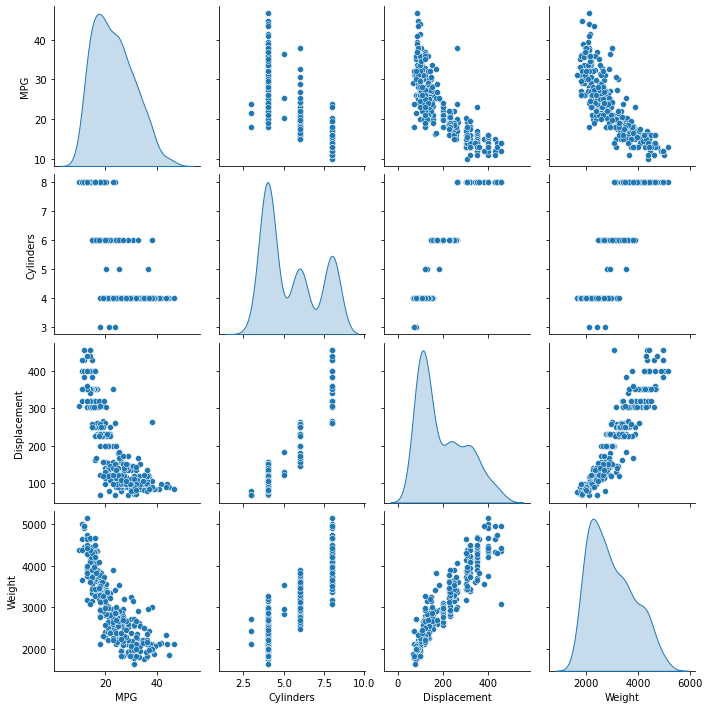

In [22]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [23]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


5. Split features from labels

  Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [24]:
train_features = train_dataset.drop('MPG', axis=1)
test_features = test_dataset.drop('MPG', axis=1)

train_labels = train_dataset['MPG'].values
test_labels = test_dataset['MPG'].values
print(train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

(314, 9) (78, 9) (314,) (78,)


# Task 2. Normalization Layer

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

In [25]:
normalizer = layers.Normalization()

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [26]:
normalizer.adapt(train_features)

2022-06-24 10:43:17.175033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We can see the feature mean and variance are stored in the layer:

In [27]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]

feature variance: [     2.88   10850.413   1446.699 709896.9        7.755     13.467
      0.147      0.158      0.235]


When the layer is called, it returns the input data, with each feature independently normalized:

In [28]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Task 3. Linear regression

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this ealier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce 1 output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. Build the Keras Sequential model:

In [29]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(1)
])

In [30]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [31]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 78ms/step


array([[-0.383],
       [-1.701],
       [-0.037],
       [-1.773],
       [ 0.227],
       [-1.756],
       [ 0.034],
       [-0.245],
       [-1.094],
       [ 1.286]], dtype=float32)

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [32]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.696],
       [ 0.759],
       [ 0.146],
       [-0.288],
       [-0.586],
       [-0.647],
       [ 0.713],
       [ 0.603],
       [-0.425]], dtype=float32)>

4. Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized and how (using the `tf.keras.optimizers.Adam`).

  Here's a list of built-in loss functions in [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For regression tasks, [common loss functions](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3) include mean squared error (MSE) and mean absolute error (MAE). Here,  MAE is preferred such that the model is more robust against outliers. 

  For optimizers, gradient descent (check this video [Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8) for a refresher) is the preferred way to optimize neural networks and many other machine learning algorithms. Read [an overview of graident descent optimizer algorithms](https://ruder.io/optimizing-gradient-descent/) for several popular gradient descent algorithms. Here, we use the popular [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), and set the learning rate at 0.1 for faster learning.  

In [36]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error')
)

5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [38]:
%%time
history = linear_model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split=0.2)

CPU times: user 2.27 s, sys: 210 ms, total: 2.48 s
Wall time: 2.2 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [39]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.472304,2.445358,95
96,2.467192,2.493114,96
97,2.478408,2.452619,97
98,2.489511,2.454298,98
99,2.467941,2.450855,99


In [40]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

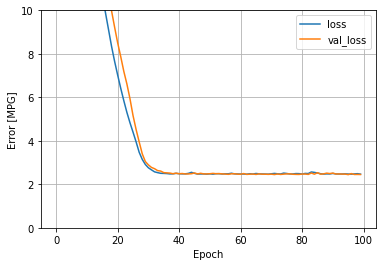

In [41]:
plot_loss(history)

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [44]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels)

3/3 [==============================] - 0s 2ms/step - loss: 2.4642


In [45]:
test_results

{'linear_model': 2.464247941970825}

# Task 4. Regression with a deep neural network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [75]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential()
  model.add(norm)
  model.add(tf.keras.layers.Dense(64, activation='sigmoid'))
  model.add(tf.keras.layers.Dense(64, activation='sigmoid'))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
  return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [76]:
dnn_model = build_and_compile_model(normalizer)

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [50]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_4 (Dense)             (None, 64)                640       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


4. Train the model with Keras `Model.fit`:

In [79]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 4.47 s, sys: 727 ms, total: 5.2 s
Wall time: 4.04 s


5. Visualize the model's training progress using the stats stored in the history object. 

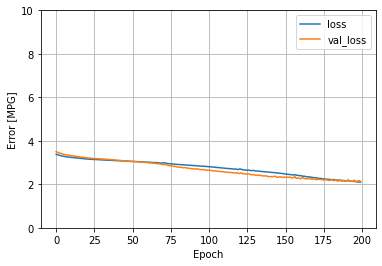

In [80]:
plot_loss(history)

Do you think the DNN model is overfitting? What gives away? 

*SEE ANSWER AT BOTTOM OF NOTEBOOK 👀*

6. Let's save the results for later comparison.

In [81]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Task 5. Make predictions

1. Since both models have been trained, we can review their test set performance:

In [55]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.464248
dnn_model,1.696694


These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

3/3 [==============================] - 0s 2ms/step


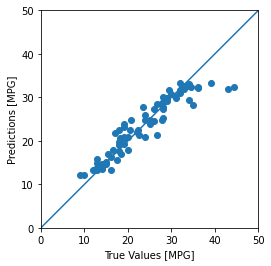

In [82]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


3. It appears that the model predicts reasonably well. Now, check the error distribution:

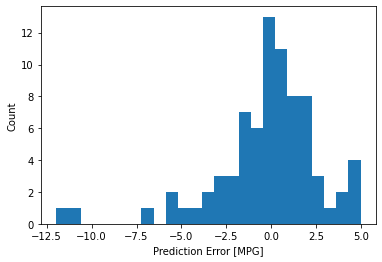

In [83]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

4. Save it for later use with `Model.save`:

In [59]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


5. Reload the model with `Model.load_model`; it gives identical output:

In [62]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [63]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.464248
dnn_model,1.696694
reloaded,1.696694


# Task 6. Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Yet there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [64]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

2. Create a plotting function to a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [65]:
def plot_displacement(x, y):
  plt.scatter(train_features['Displacement'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Displacement')
  plt.ylabel('MPG')
  plt.legend()

3. Visualize predicted MPG using the linear model.

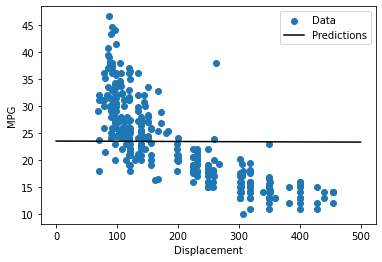

In [66]:
plot_displacement(fake.Displacement, linear_model(fake))

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 

10/10 [==============================] - 0s 1ms/step


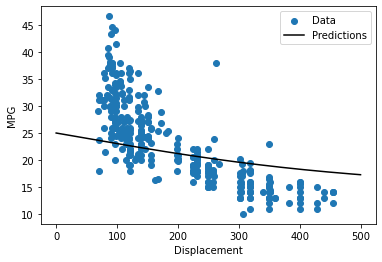

In [84]:
plot_displacement(fake.Displacement, dnn_model.predict(fake))

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 
- *SEE ANSWER AT BOTTOM OF NOTEBOOK 👀*

Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 
- *SEE ANSWER AT BOTTOM OF NOTEBOOK 👀*

In [72]:
dnn_model.layers[2].activation = 'elu'

6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techiniques that are invented for neural networks

*SEE ANSWER AT BOTTOM OF NOTEBOOK 👀*

# Task 7. AutoML - TPOT

1. Instantiate and train a TPOT auto-ML regressor.

    The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

    `generations`: 10

    `population_size`: 40

    `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

    `verbosity`: 2 (so you can see each generation's performance)

    The final line with create a Python script `tpot_products_pipeline.py` with the code to create the optimal model found by TPOT.

In [86]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring='neg_mean_squared_error',
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpop score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

/Users/troyjennings/miniconda3/envs/fourthbrain-assignments/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -8.183375095340127

Generation 2 - Current best internal CV score: -8.183375095340127

Generation 3 - Current best internal CV score: -7.990295596341778

Generation 4 - Current best internal CV score: -7.990295596341778

Generation 5 - Current best internal CV score: -7.990295596341778

Generation 6 - Current best internal CV score: -7.990295596341778

Generation 7 - Current best internal CV score: -7.990295596341778

Generation 8 - Current best internal CV score: -7.845214340797556

Generation 9 - Current best internal CV score: -7.845214340797556

Generation 10 - Current best internal CV score: -7.845214340797556

Best pipeline: ExtraTreesRegressor(SGDRegressor(PolynomialFeatures(MinMaxScaler(input_matrix), degree=2, include_bias=False, interaction_only=False), alpha=0.0, eta0=0.1, fit_intercept=True, l1_ratio=0.25, learning_rate=invscaling, loss=squared_loss, penalty=elasticnet, power_t=0.0), bootstrap=False, max_features=0.85000000000

2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [87]:
cat tpot_mpg_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -7.845214340797556
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    StackingEstimator(estimator=SGDRegr

3. Optional. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. Save the predictions as `y_pred`, and compute appropriate evaluation metric. You may find that for this simple data set, the nueral network we built outperforms the tree-based model, yet note it is not a conclusion that we can be generalized for all tabular data. 

# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.

# Notebook Answers

#### Do you think the DNN model is overfitting? What gives away? 
The hallmarks of an overfit model would be good performance on training data and poor generalization (i.e., performance) on new, 
unseen data (in this case the validation holdout set). We use a learning curve to evaluate the performance of a model on training 
data and then unseen data. In the case of our basic, deep learning model we observe that as new observations are added to the model, 
the training loss (i.e., error) decreases and then eventually flattens out. At the point the learning curve flattens out for the 
training data (around epoch 40), we see diminishing returns by adding new observations to the model. We see that same behavior on 
the valiadtion data, with a small caveat: the validation performance (i.e., loss) never "reaches" that of the training set. This is 
the behavior we would expect for a good-performing model, therefore we would rule out overfitting in this case. 

#### Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 
From the plot, we can observe the presence of linearity by a general, negative relationship between MPG and displacement 
(i.e., the scatterplot). The linear model oversimplifies the data as represented by the horizontal line for model predictions. The 
dnn model does a better job at fitting the data (lower bias) than the linear model as shown by a prediction line in the second plot. 

#### What are the other activation functions?
- `elu`: Exponential Linear Unit.
- `exponential`: Exponential activation function.
- `gelu`: Applies the Gaussian error linear unit (GELU) activation function.
- `hard_sigmoid`: Hard sigmoid activation function.
- `linear`: Linear activation function (pass-through).
- `relu`: Applies the rectified linear unit activation function.
- `selu`: Scaled Exponential Linear Unit (SELU).
- `sigmoid`: Sigmoid activation function, sigmoid(x) = 1 / (1 + exp(-x)).
- `softmax`: Softmax converts a vector of values to a probability distribution.
- `softplus`: Softplus activation function, softplus(x) = log(exp(x) + 1).
- `softsign`: Softsign activation function, softsign(x) = x / (abs(x) + 1).
- `swish`: Swish activation function, swish(x) = x * sigmoid(x).
- `tanh`: Hyperbolic tangent activation function.

#### Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 
After switching both activation functions to sigmoid functions, we observe that the predictions are better than the linear model but
worse than the dnn model using the relu activation function. This is exhibited by a prediction trendline that shows a negative slope, 
modeling the negative relationship between the MPG and diplacement, but that does not fit the data as well as the dnn model using
relu. 

#### Overfitting is a common problem for DNN models, how should we deal with it?
Much like in linear models, we can use regularization as a method for dealing with overfitting. Regularization helps to avoid overfitting
by shrinking the feature coefficient estimates towards zero to allow the model to learn from less complex features, and therefore, avoid 
learning and fitting on otherwise noisy data. Cross-validation is also a method for combating overfitting, which uses repeated sampling from
a test set and evaluating model training performance against a validation set. In doing so, we ensure that that the model has an opportunity
to learn from a more diverse set of training data and avoid fitting to a specific sample of our training set. 

#### Any other techiniques that are invented for neural networks?
- `Dropout`: Probabilistically remove inputs during training. With dropout, we drop the output of random units in any layer of the neural
    network. This has the effect of making the training process less, noisy, and therefore less complex to avoid overfitting conditions.
- `Early Stopping`: Monitor model performance on a validation set and stop training when performance degrades.
